In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
 
(x_train_all, y_train_all), (x_test,y_test) = imdb.load_data(skip_top=20, num_words=100)

17465344/17464789 [==============================] - 2s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

In [2]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [5]:
word_to_index = imdb.get_word_index()

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end =' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [6]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [7]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [8]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [9]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [10]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [11]:
import tensorflow as tf

In [12]:

class RecurrentNetwork:
    
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells     # 셀 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1h = None            # 은닉 상태에 대한 가중치
        self.w1x = None            # 입력에 대한 가중치
        self.b1 = None             # 순환층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.h = None              # 순환층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률

    def forpass(self, x):
        self.h = [np.zeros((x.shape[0], self.n_cells))]   # 은닉 상태를 초기화합니다.
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = np.swapaxes(x, 0, 1)
        # 순환 층의 선형 식을 계산합니다.
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)                    # 활성화 함수를 적용합니다.
            self.h.append(h)                   # 역전파를 위해 은닉 상태 저장합니다.
            z2 = np.dot(h, self.w2) + self.b2  # 출력층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.h[-1].T, err) / m
        b2_grad = np.sum(err) / m
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = np.swapaxes(x, 0, 1)
        
        w1h_grad = w1x_grad = b1_grad = 0
        # 셀 직전까지 그래디언트를 계산합니다.
        err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
        # 모든 타임 스텝을 거슬러가면서 그래디언트를 전파합니다.
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            # 이전 타임 스텝의 셀 직전까지 그래디언트를 계산합니다.
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)
        
        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m
    
        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()
        
        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy() # (셀 개수, 셀 개수)
        self.w1x = glorot_init((n_features, self.n_cells)).numpy() # (특성 개수, 셀 개수)
        self.b1 = np.zeros(self.n_cells)                           # 은닉층의 크기
        self.w2 = glorot_init((self.n_cells, n_classes)).numpy()   # (셀 개수, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        self.init_weights(x.shape[2], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
                batch_losses.append(loss)
            print()
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 셀의 가중치와 절편을 업데이트합니다.
        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return z > 0                 # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss)

In [13]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

에포크 12 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 13 ........................................................................................................................................................................................................................................................................................................................................................................

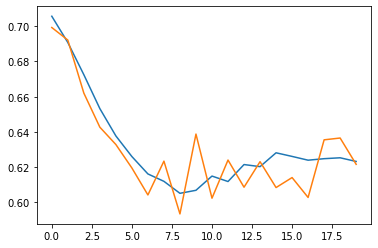

In [14]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [15]:
rn.score(x_val_onehot, y_val)

0.6494

## 텐서플로로 순환 신경망 만들기

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [17]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100)))
model.add(Dense(1, activation='sigmoid'))

model.summary() # 구조 출력

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 20s 28ms/step - loss: 0.7040 - accuracy: 0.5092 - val_loss: 0.6806 - val_accuracy: 0.5616
Epoch 2/20
625/625 [==============================] - 17s 26ms/step - loss: 0.6739 - accuracy: 0.5770 - val_loss: 0.6888 - val_accuracy: 0.5502
Epoch 3/20
625/625 [==============================] - 15s 24ms/step - loss: 0.6533 - accuracy: 0.6180 - val_loss: 0.6308 - val_accuracy: 0.6488
Epoch 4/20
625/625 [==============================] - 15s 24ms/step - loss: 0.6341 - accuracy: 0.6483 - val_loss: 0.6167 - val_accuracy: 0.6638
Epoch 5/20
625/625 [==============================] - 15s 25ms/step - loss: 0.6164 - accuracy: 0.6633 - val_loss: 0.6190 - val_accuracy: 0.6588
Epoch 6/20
625/625 [==============================] - 15s 24ms/step - loss: 0.6081 - accuracy: 0.6689 - val_loss: 0.6798 - val_accuracy: 0.6002
Epoch 7/20
625/625 [==============================] - 15s 25ms/step - loss: 0.6017 - accuracy: 0.6761 - val_loss: 0.5875 - val_accuracy:

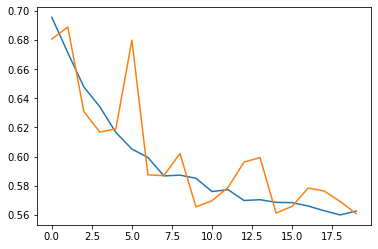

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

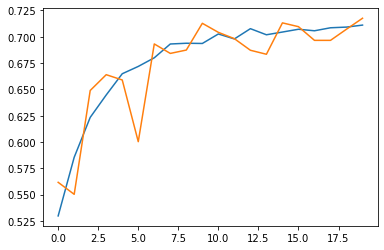

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [21]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)
print(accuracy)

0.7174000144004822


In [22]:
from tensorflow.keras.layers import Embedding

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

In [23]:
maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [24]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [25]:
from tensorflow.keras.layers import LSTM

In [26]:
model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________
